# Getting started with qUnits

In [1]:
import qrobot
import time

## Set up a basic qBrain

First, define a sensorial input:

In [2]:
# Layer 0 - Unit 0
l0_unit0 = qrobot.qunits.SensorialUnit("l0_unit_0", Ts=0.1)

In [3]:
l0_unit0

SensorialUnit "l0_unit_0-214657"
     name:	l0_unit_0
     id:	l0_unit_0-214657
     Ts:	0.1

Then, define a model and the desired bursts:

In [4]:
qrobot.models.AngularModel(n=2, tau=10)

[model: AngularModel, n: 2, tau: 10]

In [5]:
qrobot.bursts.ZeroBurst()

In [6]:
qrobot.bursts.OneBurst()

You can use objects like those to create a basic qBrain:

<img width=300 src="./06_imgs/tutorial_qunits_basicnetwork.png"/>

In [7]:
from qrobot.models import AngularModel
from qrobot.bursts import ZeroBurst, OneBurst

# Layer 1 - Unit 0
l1_unit0 = qrobot.qunits.QUnit(
    name="l1_unit0",
    model=AngularModel(n=1, tau=10),
    burst=OneBurst(),
    Ts=0.3,
    in_qunits={0: l0_unit0.id},  # Will receive Input from l0_unit0, dim 0
)

# Layer 1 - Unit 1
l1_unit1 = qrobot.qunits.QUnit(
    name="l1_unit1",
    model=AngularModel(n=1, tau=25),
    burst=ZeroBurst(),
    Ts=0.2,
    in_qunits={0: l0_unit0.id},  # Will receive input from l0_unit0, dim 1
)

In [8]:
l1_unit0

QUnit "l1_unit0-e96c53"
     name:	l1_unit0
     id:	l1_unit0-e96c53
     model:	[model: AngularModel, n: 1, tau: 10]
     burst:	<class 'qrobot.bursts.oneburst.OneBurst'>
     query:	[0.0]
     Ts:	0.3

In [9]:
l1_unit1

QUnit "l1_unit1-77319d"
     name:	l1_unit1
     id:	l1_unit1-77319d
     model:	[model: AngularModel, n: 1, tau: 25]
     burst:	<class 'qrobot.bursts.zeroburst.ZeroBurst'>
     query:	[0.0]
     Ts:	0.2

## Inputs and queries

Check the default input for `l0_unit0`:

In [10]:
l0_unit0.scalar_reading

0.0

The input units for each qUnit are:

In [11]:
print(l1_unit0.in_qunits)
print(l1_unit1.in_qunits)

{0: 'l0_unit_0-214657'}
{0: 'l0_unit_0-214657'}


Modify `l1_unit1` query:

In [12]:
l1_unit1.query = 0.8

## Real-time processing

In [13]:
l0_unit0.start()
l1_unit0.start()
l1_unit1.start()

2023-06-12 20:16:08,194 — l0_unit_0-214657 — INFO — start:72 — Starting SensorialUnit
2023-06-12 20:16:08,206 — l1_unit0-e96c53 — INFO — start:72 — Starting QUnit
2023-06-12 20:16:08,218 — l1_unit1-77319d — INFO — start:72 — Starting QUnit


Visualize the time evolution of the system from the redis status for 30 seconds changing the input with a random input:

In [14]:
import time
import json
from random import randint
from IPython.display import clear_output

statuses = []
refresh_time = 0.5  # Read statuses every 0.5 seconds

for i in range(int(30 * (1 / refresh_time))):
    # Wait and then clean the output
    time.sleep(refresh_time)
    clear_output(wait=True)

    # Change input every 2 second
    if (i * refresh_time) % 2 == 0:
        l0_unit0.scalar_reading = randint(0, 1000) / 1000

    # Read statused and store it
    status = qrobot.qunits.redis_utils.redis_status()
    statuses.append(status)

    # Print output
    print(json.dumps(status, indent=1, sort_keys=True))
    print(int(i * refresh_time), "/30 seconds")

    # Plot graph
    qbrain_graph = qrobot.graph(status)
    qrobot.draw(qbrain_graph)

{
 "l0_unit_0-214657 class": "SensorialUnit",
 "l0_unit_0-214657 output": "0.077",
 "l1_unit0-e96c53 class": "QUnit",
 "l1_unit0-e96c53 in_qunits": "{\"0\": \"l0_unit_0-214657\"}",
 "l1_unit0-e96c53 output": "1.0",
 "l1_unit0-e96c53 query": "[0.0]",
 "l1_unit0-e96c53 state": "1",
 "l1_unit1-77319d class": "QUnit",
 "l1_unit1-77319d in_qunits": "{\"0\": \"l0_unit_0-214657\"}",
 "l1_unit1-77319d output": "1.0",
 "l1_unit1-77319d query": "[0.8]",
 "l1_unit1-77319d state": "0"
}
29 /30 seconds


Read manually the latest outputs of the qunits found on the redis database:

In [15]:
l1_unit0.get_burst_output()

1.0

In [16]:
l1_unit1.get_burst_output()

1.0

Stop the processing loops:

In [17]:
l0_unit0.stop()
l1_unit0.stop()
l1_unit1.stop()

2023-06-12 20:16:40,653 — l0_unit_0-214657 — INFO — stop:83 — Stopping SensorialUnit
2023-06-12 20:16:40,655 — l0_unit_0-214657 — INFO — stop:85 — Cleaning redis
2023-06-12 20:16:40,661 — l1_unit0-e96c53 — INFO — stop:83 — Stopping QUnit
2023-06-12 20:16:40,663 — l1_unit0-e96c53 — INFO — stop:85 — Cleaning redis
2023-06-12 20:16:40,671 — l1_unit1-77319d — INFO — stop:83 — Stopping QUnit
2023-06-12 20:16:40,674 — l1_unit1-77319d — INFO — stop:85 — Cleaning redis


Flush the redis to clean all traces (should not be necessary if the qUnits processing loops stopped correctly):

In [18]:
qrobot.qunits.redis_utils.redis_status()

{}

In [19]:
qrobot.qunits.redis_utils.flush_redis()

2023-06-12 20:16:40,703 — redis — INFO — flush_redis:81 — Flushing redis database


## Visualize the results

We can visualize the time evolution of such time period:

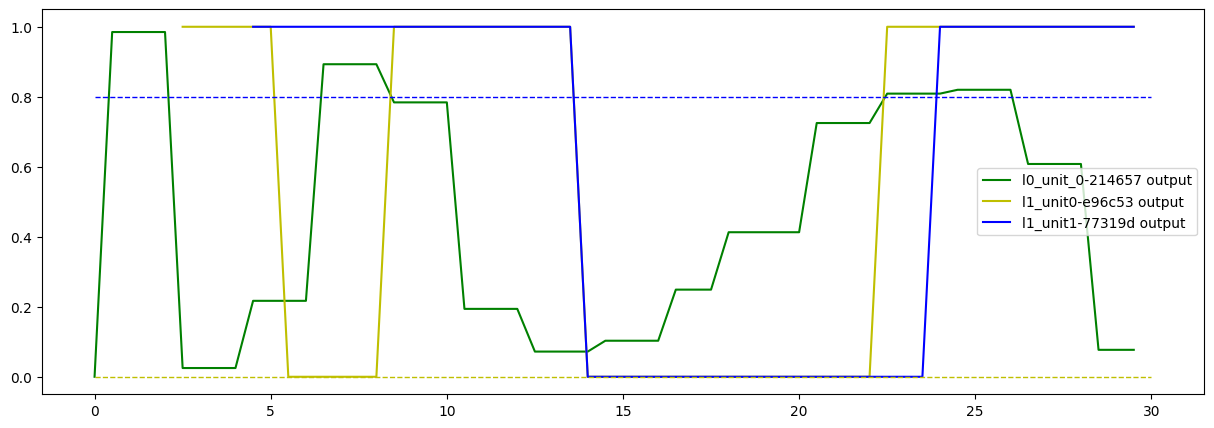

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

status_df = pd.DataFrame(statuses)
units = [l0_unit0.id + " output", l1_unit0.id + " output", l1_unit1.id + " output"]
status_df = status_df[units]
status_df = status_df.astype(np.float64)
status_df.index = status_df.index * refresh_time

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Plot time evolution
styles = ["g", "y", "b"]
status_df[units].plot(style=styles, ax=ax)
# Plot queries as dashed lines
ax.hlines(
    y=l1_unit0.query, xmin=0, xmax=30, linewidth=1, color="y", linestyles="dashed"
)
ax.hlines(
    y=l1_unit1.query, xmin=0, xmax=30, linewidth=1, color="b", linestyles="dashed"
)
plt.show()

Focusing on `l1_unit0`:

QUnit "l1_unit0-e96c53"
     name:	l1_unit0
     id:	l1_unit0-e96c53
     model:	[model: AngularModel, n: 1, tau: 10]
     burst:	<class 'qrobot.bursts.oneburst.OneBurst'>
     query:	[0.0]
     Ts:	0.3


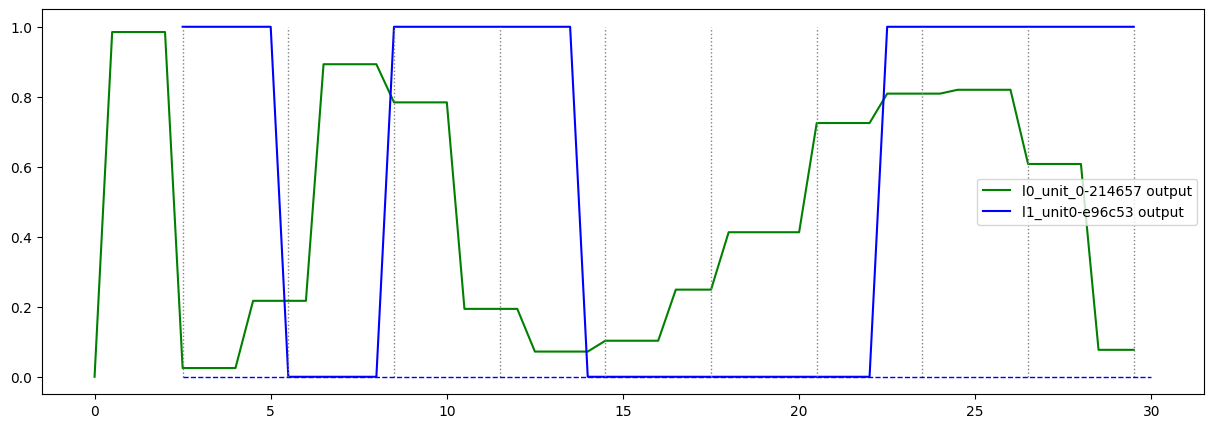

In [21]:
print(l1_unit0)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Plot time evolution
units = [l0_unit0.id + " output", l1_unit0.id + " output"]
styles = ["g", "b"]
status_df[units].plot(style=styles, ax=ax)
# Plot time windows
t_start = status_df[l1_unit0.id + " output"].dropna().index[0]
t_step = l1_unit0.model.tau * l1_unit0.Ts
t_windows = np.arange(t_start, 31, t_step)
plt.vlines(x=t_windows, ymin=0, ymax=1, colors="gray", ls="dotted", lw=1)
# Plot query as dashed line
ax.hlines(y=l1_unit0.query, xmin=t_start, xmax=30, linewidth=1, color="b", ls="dashed")
plt.show()

Focusing on `l1_unit1`:

QUnit "l1_unit1-77319d"
     name:	l1_unit1
     id:	l1_unit1-77319d
     model:	[model: AngularModel, n: 1, tau: 25]
     burst:	<class 'qrobot.bursts.zeroburst.ZeroBurst'>
     query:	[0.8]
     Ts:	0.2


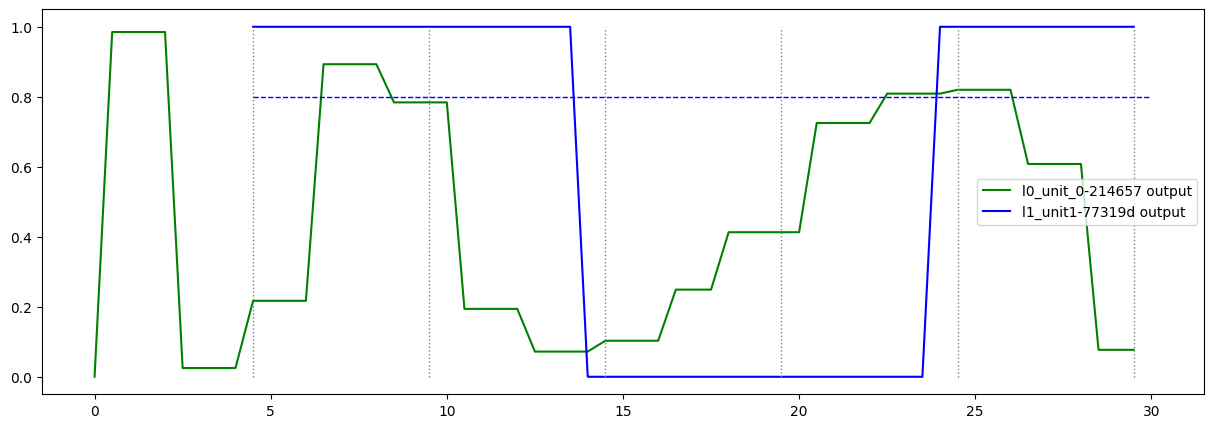

In [22]:
print(l1_unit1)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Plot time evolution
units = [l0_unit0.id + " output", l1_unit1.id + " output"]
styles = ["g", "b"]
status_df[units].plot(style=styles, ax=ax)
# Plot time windows
t_start = status_df[l1_unit1.id + " output"].dropna().index[0]
t_step = l1_unit1.model.tau * l1_unit1.Ts
t_windows = np.arange(t_start, 31, t_step)
plt.vlines(x=t_windows, ymin=0, ymax=1, colors="gray", ls="dotted", lw=1)
# Plot query as dashed line
ax.hlines(y=l1_unit1.query, xmin=t_start, xmax=30, linewidth=1, color="b", ls="dashed")
plt.show()

## Detailed logs

Print the last 30 lines of the log:

In [23]:
def print_log(filter_by: "list[str]" = None, n_lines: int = 30):
    log_file = qrobot._logger.log_file()
    i = 0
    with open(log_file) as log:
        for line in log.readlines()[-n_lines:]:
            if filter_by is None or all(x in line for x in filter_by):
                print(line, end="")
                i += 1
            if i >= n_lines:
                break


print_log()

2023-06-12 20:16:40,114 — l0_unit_0-214657 — DEBUG — _unit_task:80 — Writing input on redis
2023-06-12 20:16:40,208 — l1_unit1-77319d — DEBUG — _unit_task:198 — Temporal window event 4/25
2023-06-12 20:16:40,212 — l1_unit1-77319d — DEBUG — _unit_task:203 — input_vector=[0.077]
2023-06-12 20:16:40,220 — l0_unit_0-214657 — DEBUG — _unit_task:79 — scalar_reading=0.077
2023-06-12 20:16:40,220 — l0_unit_0-214657 — DEBUG — _unit_task:80 — Writing input on redis
2023-06-12 20:16:40,325 — l0_unit_0-214657 — DEBUG — _unit_task:79 — scalar_reading=0.077
2023-06-12 20:16:40,325 — l0_unit_0-214657 — DEBUG — _unit_task:80 — Writing input on redis
2023-06-12 20:16:40,329 — l1_unit0-e96c53 — DEBUG — _unit_task:198 — Temporal window event 4/10
2023-06-12 20:16:40,331 — l1_unit0-e96c53 — DEBUG — _unit_task:203 — input_vector=[0.077]
2023-06-12 20:16:40,416 — l1_unit1-77319d — DEBUG — _unit_task:198 — Temporal window event 5/25
2023-06-12 20:16:40,421 — l1_unit1-77319d — DEBUG — _unit_task:203 — input_v

Print the last lines of the log only for `l1_unit1`:

In [24]:
print_log(["l1_unit1"], 200)

2023-06-12 20:16:35,810 — l1_unit1-77319d — DEBUG — _unit_task:198 — Temporal window event 8/25
2023-06-12 20:16:35,814 — l1_unit1-77319d — DEBUG — _unit_task:203 — input_vector=[0.82]
2023-06-12 20:16:36,016 — l1_unit1-77319d — DEBUG — _unit_task:198 — Temporal window event 9/25
2023-06-12 20:16:36,017 — l1_unit1-77319d — DEBUG — _unit_task:203 — input_vector=[0.82]
2023-06-12 20:16:36,218 — l1_unit1-77319d — DEBUG — _unit_task:198 — Temporal window event 10/25
2023-06-12 20:16:36,219 — l1_unit1-77319d — DEBUG — _unit_task:203 — input_vector=[0.82]
2023-06-12 20:16:36,421 — l1_unit1-77319d — DEBUG — _unit_task:198 — Temporal window event 11/25
2023-06-12 20:16:36,426 — l1_unit1-77319d — DEBUG — _unit_task:203 — input_vector=[0.82]
2023-06-12 20:16:36,630 — l1_unit1-77319d — DEBUG — _unit_task:198 — Temporal window event 12/25
2023-06-12 20:16:36,633 — l1_unit1-77319d — DEBUG — _unit_task:203 — input_vector=[0.82]
2023-06-12 20:16:36,836 — l1_unit1-77319d — DEBUG — _unit_task:198 — Tem

In [25]:
print("Time window time:", l1_unit1.Ts * l1_unit1.model.tau, "seconds")
print_log(["l1_unit1", "Output state = "], 1000)

Time window time: 5.0 seconds
2023-06-12 20:16:18,500 — l1_unit1-77319d — DEBUG — _unit_task:216 — Output state = 0
2023-06-12 20:16:23,725 — l1_unit1-77319d — DEBUG — _unit_task:216 — Output state = 1
2023-06-12 20:16:28,941 — l1_unit1-77319d — DEBUG — _unit_task:216 — Output state = 1
2023-06-12 20:16:34,151 — l1_unit1-77319d — DEBUG — _unit_task:216 — Output state = 0
2023-06-12 20:16:39,376 — l1_unit1-77319d — DEBUG — _unit_task:216 — Output state = 0
